# Modelling
### Modelling approaches:
Vectorizering approach
1. Countvecctorizer
2. TfidfVectorizer

Modelling Approach
1. LogisticRegression
2. Multinomial

In [101]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline
sns.set(font_scale=1.5)

In [102]:
#Import csv
df = pd.read_csv('textfeature.csv')

In [103]:
df.head()

,text_feature,subreddit
0,husband never cheers dont know itwhen fight sa...,1
1,things wished knew getting married general lif...,1
2,cant allso going sound awful goes ive married ...,1
3,engagement ring men fianc got engaged week ago...,1
4,happily married still think women recently got...,1


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix


#### Define X and y
1. Check between CountVectorizer and Tfidfvectorizer which approach would provide a better scoring
2. Employ Logistic Regression

In [105]:
X = df.text_feature
y = df.subreddit
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=27,stratify=y)

Basline score is as follows

In [106]:
y_train.value_counts(normalize=True)

0    0.570175
1    0.429825
Name: subreddit, dtype: float64

Baseline accuracy approximately is 57% 

In [107]:
cat1,cat2 = 'Marriage', 'Divorce'

#Countvectorizer and LogisticRegression

In [108]:
log_model = make_pipeline(CountVectorizer(),
                         LogisticRegression(solver='lbfgs', multi_class='auto', random_state=27)
                         )
cv_score = cross_val_score(log_model,X_train,y_train,cv=10, scoring ='roc_auc')
log_model.fit(X_train,y_train)
pred = log_model.predict(X_test)
score = roc_auc_score(y_test,pred)
print('cv_score : {}, roc_auc_score : {}'.format(cv_score.mean(),score))
print('Number of features : {}'.format(len(log_model.named_steps.countvectorizer.get_feature_names())))

cv_score : 0.8983713977431103, roc_auc_score : 0.831981981981982
Number of features : 12023


#Tfidfvectorizer and LogisticRegression

In [109]:
log_model = make_pipeline(TfidfVectorizer(),
                         LogisticRegression(solver='lbfgs', multi_class='auto', random_state=27)
                         )
cv_score = cross_val_score(log_model,X_train,y_train,cv=10, scoring ='roc_auc')
log_model.fit(X_train,y_train)
pred = log_model.predict(X_test)
score = roc_auc_score(y_test,pred)
print('cv_score : {}, roc_auc_score : {}'.format(cv_score.mean(),score))
print('Number of features : {}'.format(len(log_model.named_steps.tfidfvectorizer.get_feature_names())))

cv_score : 0.9340365508249786, roc_auc_score : 0.8499306999306999
Number of features : 12023


 1. TFIDF Vectoriser perform better compare to count vectorizer in both cv_score and roc_auc_score
 2. #Gridsearch using both Tfidfvectorizer and employ parameters to gridsearch.

In [110]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])
# Explore parameters for Tfidfvectorizer
params = dict(
    cvec__stop_words = [None, 'english'],
    cvec__max_df = [0.90, 1.0],
    cvec__min_df = [0.0 , 0.01],
    cvec__ngram_range = [(1, 1), (1, 3)],
    cvec__max_features = [500,1000,3000]  
)

lr_cvec = GridSearchCV(pipe, params, cv = 10, scoring='roc_auc', iid=False, n_jobs=-1, verbose=1)
lr_cvec.fit(X_train, y_train)

best_prams   = lr_cvec.best_params_
train_score  = lr_cvec.best_score_
feature_name = lr_cvec.best_estimator_.named_steps.cvec.get_feature_names()

#Initialise the model
parameter = dict((k.replace('cvec__',''),v) for k,v in lr_cvec.best_params_.items())

lr_cvec_model = make_pipeline(CountVectorizer(**parameter),LogisticRegression())
lr_cvec_model.fit(X_train,y_train)
pred = lr_cvec_model.predict(X_test)
test_score = roc_auc_score(y_test,pred)

print("Best params: {}".format(best_prams))
print('Train score: {}, Test score {}'.format(round(train_score, 4), round(test_score, 4)))
print('Number of features: {}'.format(len(feature_name)))


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  7.2min finished


Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}
Train score: 0.8998, Test score 0.8235
Number of features: 3000


In [111]:
#Functions to Plot ROC curve with AUC scoring
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

def Calculate(pred_df,thresholds):
    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    
    return tpr_values,fpr_values

def ROC_curve(y_test, X_test,model):
    
    pred_proba = [i[1] for i in model.predict_proba(X_test)]

    pred_df = pd.DataFrame({'true_values': y_test,
                           'pred_probs': pred_proba})

    roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

    # Create figure.
    plt.figure(figsize = (10,7))

    # Create threshold values. (Dashed red line in image.)
    thresholds = np.linspace(0, 1, 200)
    
    tpr_values,fpr_values = Calculate(pred_df,thresholds)
    
    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);
              
def confusion(X_test,y_test,model):
    pred = model.predict(X_test)
    df_confusion = pd.DataFrame(confusion_matrix(y_test,pred), 
             index = ['Predict {}'.format(cat1), 'Predict {}'.format(cat2)],
             columns = ['actual  {}'.format(cat1), 'actual  {}'.format(cat2)]
            )
    display(df_confusion)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    accuracy          = round((tp+tn)/(tp+fp+tn+fn),4)*100
    misclassification = round((fp+fn)/(tp+fp+tn+fn),4)*100
    precision         = round(tp/(tp+fp),4) * 100
    
    print('** Accuracy %: {}% **'     .format(accuracy))
    print('Misclassification %: {}&'.format(misclassification))
    print('Precision %: {}'           .format(round(tp/(tp+fp),4)))
    print('Recall: {}'                .format(round(tp/(tp+fn),4)))
    print('Specificity: {}'           .format(round(tn/(tn+fp),4)))
    
    return accuracy, misclassification
              
combine_info=[]
def print_out(gs,best_prams,train_score,test_score,feature_name,model ):
    print('''
    ###########################
    {} model
    ###########################    
    '''.format(gs))
    print("Best params: {}".format(best_prams))
    print('Train score: {}, Test score {}'.format(train_score, test_score))
    print('Number of features: {}'.format(len(feature_name)))

    accuracy,misclassification = confusion(X_test,y_test,model)
    
    ROC_curve(y_test,X_test,model)
    
    ls = [gs,train_score,test_score,len(feature_name),accuracy,misclassification]
    combine_info.append(ls)
    return 


              


    ###########################
    Cvec_LogisticRegression model
    ###########################    
    
Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}
Train score: 0.8998471429213684, Test score 0.8234753984753985
Number of features: 3000


,actual Marriage,actual Divorce
Predict Marriage,167,28
Predict Divorce,31,117


** Accuracy %: 82.8% **
Misclassification %: 17.2&
Precision %: 0.8069
Recall: 0.7905
Specificity: 0.8564


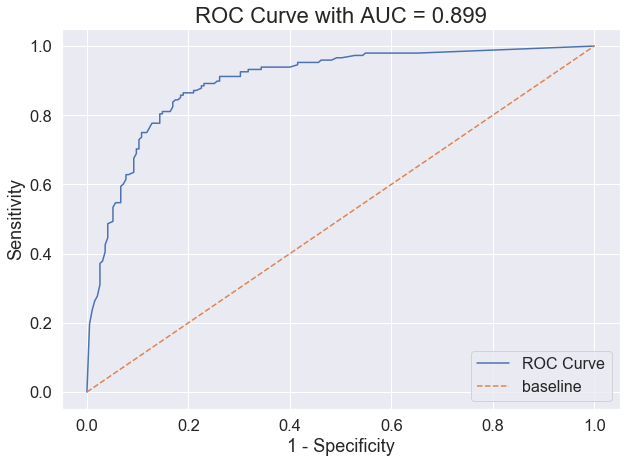

In [112]:
print_out('Cvec_LogisticRegression',best_prams,train_score,test_score,feature_name,lr_cvec_model)

In [113]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])
# Explore parameters for Tfidfvectorizer
params = dict(
    tfidf__stop_words = [None, 'english'],
    tfidf__max_df = (0.90, 0.95, 1.0),
    tfidf__min_df = (0,0.01,0.1),
    tfidf__ngram_range = [(1, 1),(1,3)],
    tfidf__max_features = [500,1000,3000]
)

lr_tfidf = GridSearchCV(pipe, params, cv = 10, scoring='roc_auc', iid=False, n_jobs=-1, verbose=1)
lr_tfidf.fit(X_train, y_train)

best_prams   = lr_tfidf.best_params_
train_score  = lr_tfidf.best_score_
feature_name = lr_tfidf.best_estimator_.named_steps.tfidf.get_feature_names()



#Initialise the model
parameter = dict((k.replace('tfidf__',''),v) for k,v in lr_tfidf.best_params_.items())

lr_tfidf_model = make_pipeline(TfidfVectorizer(**parameter),LogisticRegression())
lr_tfidf_model.fit(X_train,y_train)
pred = lr_tfidf_model.predict(X_test)
test_score = roc_auc_score(y_test,pred)

print("Best params: {}".format(best_prams))
print('Train score: {}, Test score {}'.format(round(train_score, 4), round(test_score, 4)))
print('Number of features: {}'.format(len(feature_name)))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 12.0min finished


Best params: {'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 0, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': 'english'}
Train score: 0.9363, Test score 0.8634
Number of features: 3000



    ###########################
    Tfidf_LogisticRegression model
    ###########################    
    
Best params: {'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 0, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': 'english'}
Train score: 0.9363192914624825, Test score 0.8634442134442135
Number of features: 3000


,actual Marriage,actual Divorce
Predict Marriage,176,19
Predict Divorce,26,122


** Accuracy %: 86.88% **
Misclassification %: 13.120000000000001&
Precision %: 0.8652
Recall: 0.8243
Specificity: 0.9026


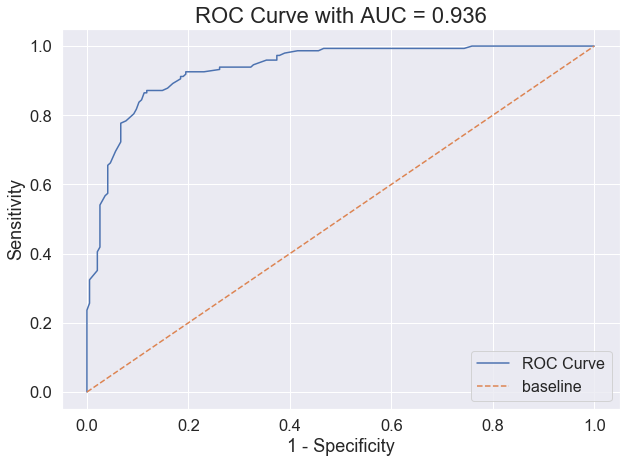

In [114]:
print_out('Tfidf_LogisticRegression',best_prams,train_score,test_score,feature_name,lr_tfidf_model)

TfidfVectoriser perform better for logistic Regression modelling. 
1. The success of the model is dependent on the accuracy of the model. 
    Tfidfvectorizer with LogisticRegression accuracy score is approximately 86%, slightly beating out Countvectorizer with Logistic Regression accuracy score of approximately 83%. Both models are extremely close.
2. The AUC scoring for ROC curve perform better as for Tfidfvectorizer with Logistic Regression modelling.

## 2nd approach using MultinomialNB()

In [115]:
X = df.text_feature
y = df.subreddit
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=27,stratify=y)


In [116]:
mnb_model = make_pipeline(CountVectorizer(),MultinomialNB())

cv_score = cross_val_score(mnb_model,X_train,y_train,cv=10, scoring ='roc_auc')
mnb_model.fit(X_train,y_train)
pred = mnb_model.predict(X_test)
score = roc_auc_score(y_test,pred)
print('cv_score : {}, roc_auc_score : {}'.format(cv_score.mean(),score))
print('Number of features : {}'.format(len(mnb_model.named_steps.countvectorizer.get_feature_names())))

cv_score : 0.9178562413151454, roc_auc_score : 0.8006503920171062
Number of features : 11661


In [117]:
mnb_model = make_pipeline(TfidfVectorizer(),MultinomialNB())

cv_score = cross_val_score(mnb_model,X_train,y_train,cv=10, scoring ='roc_auc')
mnb_model.fit(X_train,y_train)
pred = mnb_model.predict(X_test)
score = roc_auc_score(y_test,pred)
print('cv_score : {}, roc_auc_score : {}'.format(cv_score.mean(),score))
print('Number of features : {}'.format(len(mnb_model.named_steps.tfidfvectorizer.get_feature_names())))

cv_score : 0.909419250686374, roc_auc_score : 0.5855755523877405
Number of features : 11661


In [118]:
# Explore parameters for Countvectorizer

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

params = dict(
    cvec__stop_words = [None, 'english'],
    cvec__max_df = [0.90, 0.98, 1.0],
    cvec__min_df = [0.0 , 0.01, 0.1],
    cvec__ngram_range = [(1, 1), (1, 3)],
    cvec__max_features = [500,1000,3000]
)

mnb_cvec = GridSearchCV(pipe, params, cv = 10, scoring='roc_auc', iid=False, n_jobs=-1, verbose=1)
mnb_cvec.fit(X_train, y_train)

best_prams   = mnb_cvec.best_params_
train_score  = mnb_cvec.best_score_
feature_name = mnb_cvec.best_estimator_.named_steps.cvec.get_feature_names()

#Initialise the model
parameter = dict((k.replace('cvec__',''),v) for k,v in mnb_cvec.best_params_.items())

mnb_cvec_model = make_pipeline(CountVectorizer(**parameter),MultinomialNB())
mnb_cvec_model.fit(X_train,y_train)
pred = mnb_cvec_model.predict(X_test)
test_score = roc_auc_score(y_test,pred)

print("Best params: {}".format(best_prams))
print('Train score: {}, Test score {}'.format(round(train_score, 4), round(test_score, 4)))
print('Number of features: {}'.format(len(feature_name)))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 10.6min finished


Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}
Train score: 0.9207, Test score 0.8311
Number of features: 3000



    ###########################
    Cvec_MultinomialNB model
    ###########################    
    
Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}
Train score: 0.9206565389442103, Test score 0.8310762651461155
Number of features: 3000


,actual Marriage,actual Divorce
Predict Marriage,204,40
Predict Divorce,32,152


** Accuracy %: 83.17999999999999% **
Misclassification %: 16.82&
Precision %: 0.7917
Recall: 0.8261
Specificity: 0.8361


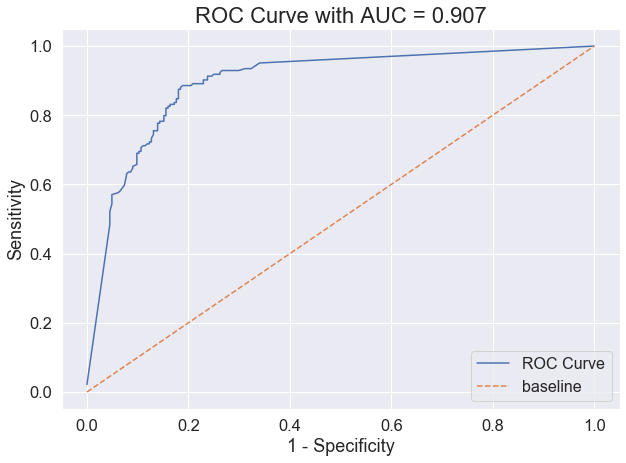

In [119]:
print_out('Cvec_MultinomialNB',best_prams,train_score,test_score,feature_name, mnb_cvec_model)

In [120]:
# Explore parameters for Tfidfvectorizer
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])
# print(pipe.get_params().keys())
params = dict(
    tfidf__stop_words   = [None,'english'],
    tfidf__max_df       = [0.90, 1.0],
    tfidf__min_df       = [0.0, 0.01],
    tfidf__ngram_range  = [(1,1), (1,3)],
    tfidf__max_features = [500,1000,3000]
)

mnb_tfidf = GridSearchCV(pipe,params, cv = 10 , scoring='roc_auc', iid=False, n_jobs=-1, verbose=1)
mnb_tfidf.fit(X_train, y_train)

best_prams   = mnb_tfidf.best_params_
train_score  = mnb_tfidf.best_score_
feature_name = mnb_tfidf.best_estimator_.named_steps.tfidf.get_feature_names()

#Initialise the model
parameter = dict((k.replace('tfidf__',''),v) for k,v in mnb_tfidf.best_params_.items())

mnb_tfidf_model = make_pipeline(TfidfVectorizer(**parameter),MultinomialNB())
mnb_tfidf_model.fit(X_train,y_train)
pred = mnb_tfidf_model.predict(X_test)
test_score = roc_auc_score(y_test,pred)

print("Best params: {}".format(best_prams))
print('Train score: {}, Test score {}'.format(round(train_score, 4), round(test_score, 4)))
print('Number of features: {}'.format(len(feature_name)))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.0min finished


Best params: {'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': None}
Train score: 0.9293, Test score 0.7716
Number of features: 3000



    ###########################
    Tfidf_MultinomialNB model
    ###########################    
    
Best params: {'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': None}
Train score: 0.9292700935680388, Test score 0.7715609408410549
Number of features: 3000


,actual Marriage,actual Divorce
Predict Marriage,228,16
Predict Divorce,72,112


** Accuracy %: 79.44% **
Misclassification %: 20.560000000000002&
Precision %: 0.875
Recall: 0.6087
Specificity: 0.9344


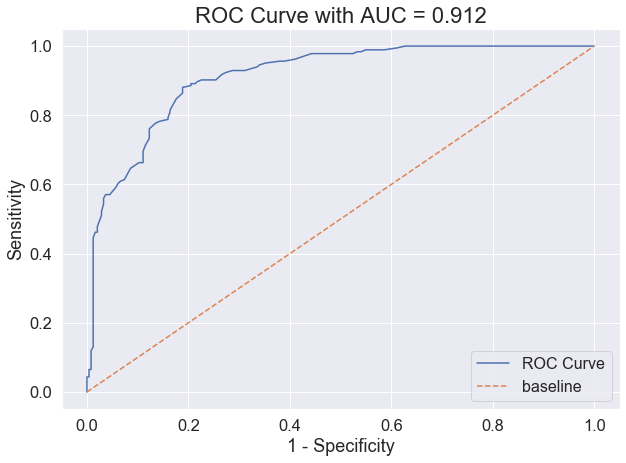

In [121]:
print_out('Tfidf_MultinomialNB',best_prams,train_score,test_score,feature_name,mnb_tfidf_model)

Surprisingly, Countvectorizer perform better than Tfidfvectorizer when doing MultinomialNB. 
1. Accuracy socre of Countcevtorzer with MultinomialNB is approximately 83% which is significantly higher as compared to Tfidfvectorizer with MultinomialNB 74.53%. 
2. However the AUC scoring for ROC curve is almost identical. 

However Accuracy is the determining factor for this analysis.

#Overall dataframe

In [122]:
df_collection = pd.DataFrame(data=combine_info, columns =['model','train_score','test_score','number_of_features', 'accuracy', 'misclassification'])
df_collection

,model,train_score,test_score,number_of_features,accuracy,misclassification
0,Cvec_LogisticRegression,0.899847,0.823475,3000,82.80,17.20
1,Tfidf_LogisticRegression,0.936319,0.863444,3000,86.88,13.12
2,Cvec_MultinomialNB,0.920657,0.831076,3000,83.18,16.82
3,Tfidf_MultinomialNB,0.929270,0.771561,3000,79.44,20.56


In [123]:
# Dump model for production use on deployment
import joblib
joblib.dump(lr_tfidf_model, 'Marriage_Divorce.pkl')

['Marriage_Divorce.pkl']

## Conclusion and Recommendations


- Our TifdfVectoriser with Logistic Regression classifier performed best out of all 4 models. 

- The difference in the train and test score is slightly wider than expected. This is probably due to the high amount of features choosen (3000 features per model selected). 

- The accuracy score of 84% is slightly higher than expected, as seen in the dataframe above. This is within expectations because the topics of our two chosen subreddits differ slightly.

- Scope for future improvements:
    - Optimize stop words and explore strategies for stemming and lemmatization
    - Try ensemble models, such as random forest classifier
    - Ability for model to classify more than two subreddits

In regards to the problem statement, our model will provide a reasonable accurate classification on the 100,000 couples participating in this study by scraping off their social media webpages.

Further development on Sentimental analysis could prove useful especially in regards to dealing with the objective of the project.